## Install the package dependencies before running this notebook

In [500]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os, os.path 
import numpy as np
import pickle
from glob import glob
import pickle
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import pandas as pd

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [501]:
ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city:str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.city = city
        self.split = split

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        
#         print(type(self.inputs))
#         print(type(self.outputs))
        
        if self.split == 'train':
            data = (torch.from_numpy(self.inputs[idx]).float(), torch.from_numpy(self.outputs[idx]).float())
        else:
            data = (torch.from_numpy(self.inputs[idx]).float())
#         print(type(data[0]))
#         print(type(data[1]))
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset = ArgoverseDataset(city = city, split = split)

# Exploratory Analysis

In [502]:
# initialize datasets

train_datasets = []
test_datasets = []

for city in cities:
    train_dataset = ArgoverseDataset(city=city, split='train')
    test_dataset = ArgoverseDataset(city=city, split='test')
    
    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)
    
for train in train_datasets:
    print(f'{train.city}: {train.inputs.shape}')

austin: (43041, 50, 2)
miami: (55029, 50, 2)
pittsburgh: (43544, 50, 2)
dearborn: (24465, 50, 2)
washington-dc: (25744, 50, 2)
palo-alto: (11993, 50, 2)


In [ ]:
x1 = []
y1 = []
for i in range(train_datasets[0].inputs.shape[1]):
    curr = train_datasets[0].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(-2800,4300,50),np.arange(-4300,3200,50)],
                                        vmin=0, vmax=14000)
ax1.set_title("aggregate inputs")
fig1.colorbar(im, ax=ax1)

x2 = []
y2 = []
for i in range(train_datasets[0].outputs.shape[1]):
    curr = train_datasets[0].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig1.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(-2800,4300,50),np.arange(-4300,3200,50)],
                                       vmin=0, vmax=14000)
ax2.set_title("aggregate outputs")
fig1.colorbar(im, ax=ax2)

print(f'aggregate stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x1: {max(x2)}')
print(f'min y2: {min(y2)}, max y1: {max(y2)}')

austin stats:
min x1: -2754.1364660823856, max x1: 4241.488092484203
min y1: -4211.255435808992, max y1: 3133.064101216354
min x2: -2751.731376460925, max x1: 4212.124011297809
min y2: -4204.383097720112, max y1: 3176.8867140461452


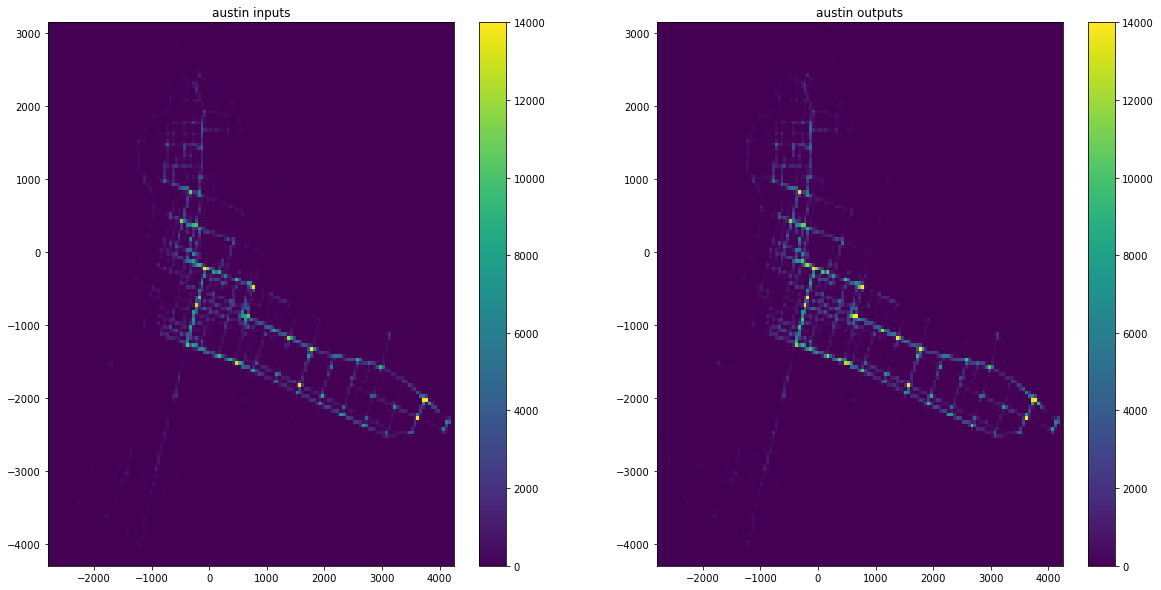

In [110]:
x1 = []
y1 = []
for i in range(train_datasets[0].inputs.shape[1]):
    curr = train_datasets[0].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(-2800,4300,50),np.arange(-4300,3200,50)],
                                        vmin=0, vmax=14000)
ax1.set_title("austin inputs")
fig1.colorbar(im, ax=ax1)

x2 = []
y2 = []
for i in range(train_datasets[0].outputs.shape[1]):
    curr = train_datasets[0].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig1.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(-2800,4300,50),np.arange(-4300,3200,50)],
                                       vmin=0, vmax=14000)
ax2.set_title("austin outputs")
fig1.colorbar(im, ax=ax2)

print(f'austin stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x1: {max(x2)}')
print(f'min y2: {min(y2)}, max y1: {max(y2)}')

miami stats:
min x1: -9222.61470641863, max x1: 7315.477589872011
min y1: -4535.476698992521, max y1: 5311.323608033551
min x2: -9231.75573256512, max x2: 7321.264226843908
min y2: -4539.313391138148, max y2: 5312.344976073972


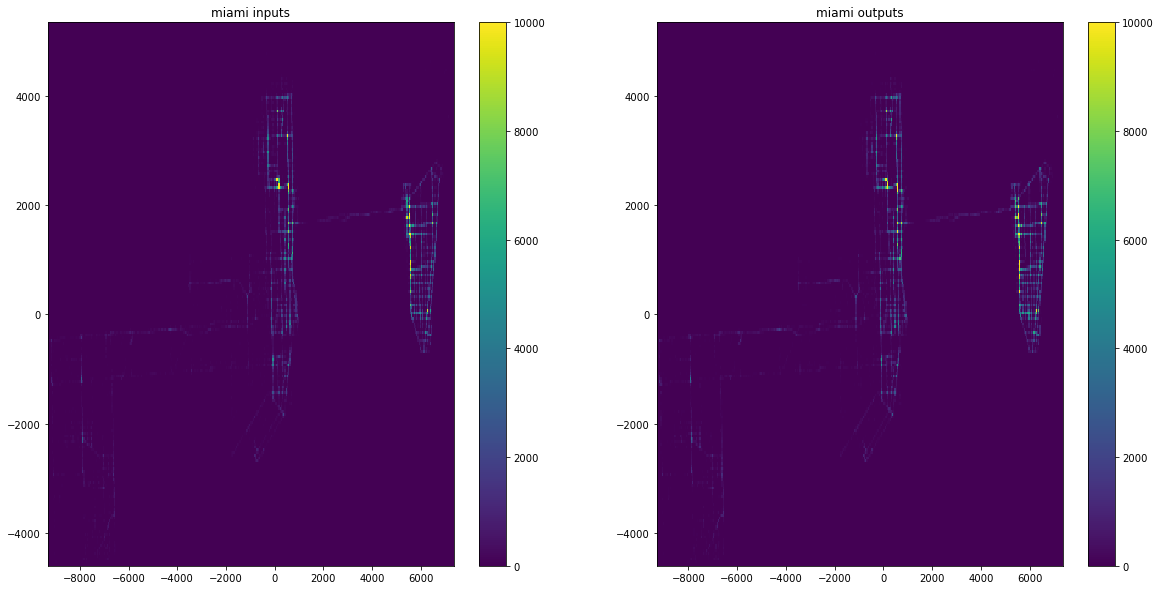

In [10]:
x1 = []
y1 = []
for i in range(train_datasets[1].inputs.shape[1]):
    curr = train_datasets[1].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig2 = plt.figure(figsize=(20,10))
ax1 = fig2.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(-9300,7400,50),np.arange(-4600,5400,50)],
                                       vmin=0, vmax=10000)
fig1.colorbar(im, ax=ax1)
ax1.set_title("miami inputs")

x2 = []
y2 = []
for i in range(train_datasets[1].outputs.shape[1]):
    curr = train_datasets[1].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig2.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(-9300,7400,50),np.arange(-4600,5400,50)],
                                       vmin=0, vmax=10000)
fig1.colorbar(im, ax=ax2)
ax2.set_title("miami outputs")

print(f'miami stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

pittsburgh stats:
min x1: 470.0385747929399, max x1: 8027.560224965913
min y1: -1824.8781533993258, max y1: 3623.293190269404
min x2: 435.3312424305216, max x2: 7998.166750186447
min y2: -1826.5365824864757, max y2: 3609.5550921196677


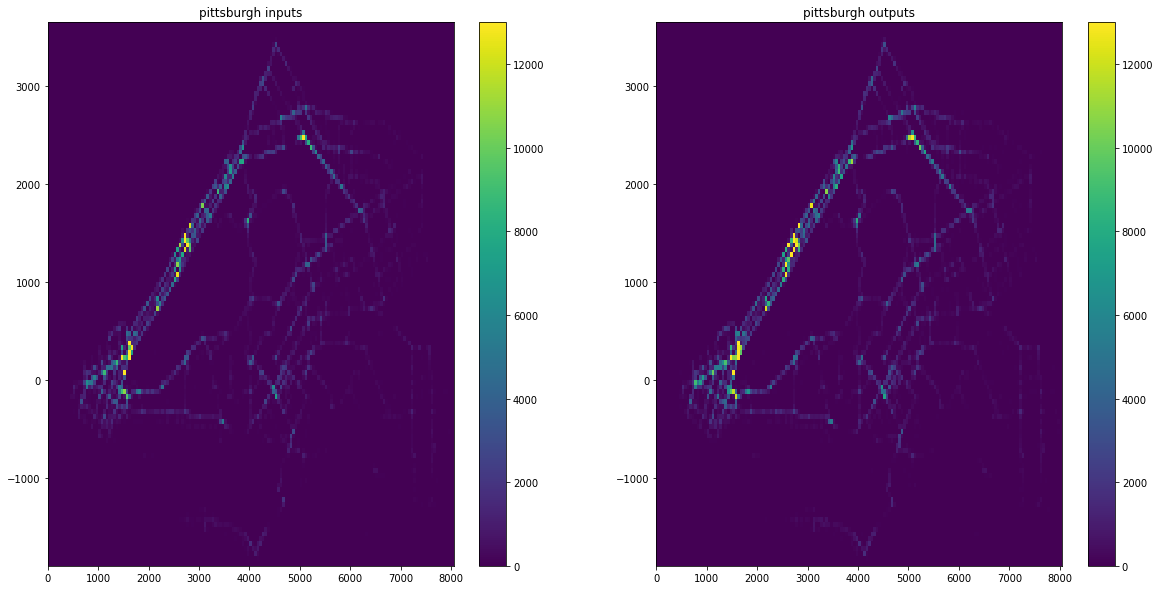

In [6]:
x1 = []
y1 = []
for i in range(train_datasets[2].inputs.shape[1]):
    curr = train_datasets[2].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig3 = plt.figure(figsize=(20,10))
ax1 = fig3.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(0,8100,50),np.arange(-1900,3700,50)],
                                       vmin=0, vmax=13000)
fig3.colorbar(im, ax=ax1)
ax1.set_title("pittsburgh inputs")

x2 = []
y2 = []
for i in range(train_datasets[2].outputs.shape[1]):
    curr = train_datasets[2].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig3.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(0,8100,50),np.arange(-1900,3700,50)],
                                       vmin=0, vmax=13000)
fig3.colorbar(im, ax=ax2)
ax2.set_title("pittsburgh outputs")

print(f'pittsburgh stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

dearborn stats:
min x1: -6052.987510579862, max x1: 13295.106948135915
min y1: -775.5496515681594, max y1: 7098.011178254607
min x2: -6023.666045042145, max x2: 13318.46759457012
min y2: -805.0999942882692, max y2: 7048.918470569207


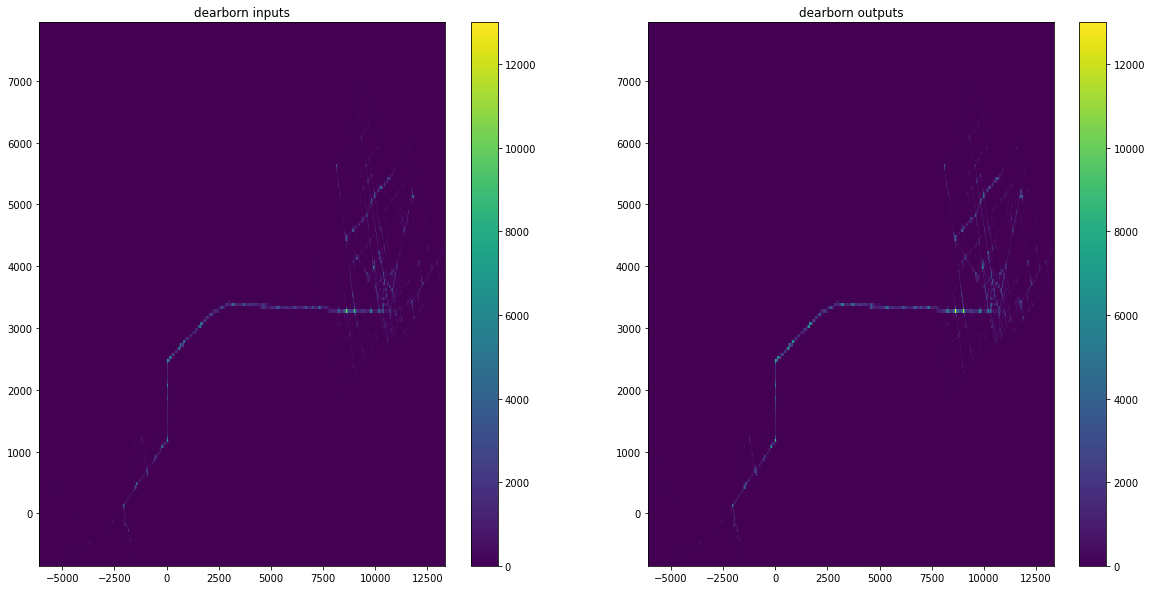

In [10]:
x1 = []
y1 = []
for i in range(train_datasets[3].inputs.shape[1]):
    curr = train_datasets[3].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig4 = plt.figure(figsize=(20,10))
ax1 = fig4.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(-6100,13400,50),np.arange(-850,8000,50)],
                                       vmin=0, vmax=13000)
fig4.colorbar(im, ax=ax1)
ax1.set_title("dearborn inputs")

x2 = []
y2 = []
for i in range(train_datasets[3].outputs.shape[1]):
    curr = train_datasets[3].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig4.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(-6100,13400,50),np.arange(-850,8000,50)],
                                       vmin=0, vmax=13000)
fig4.colorbar(im, ax=ax2)
ax2.set_title("dearborn outputs")

print(f'dearborn stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

washington-dc stats:
min x1: 301.94388927146895, max x1: 6985.247910537663
min y1: -1239.0390667058505, max y1: 5638.251211036229
min x2: 275.6506963245901, max x2: 6987.343566945223
min y2: -1232.9342389600067, max y2: 5689.173968560887


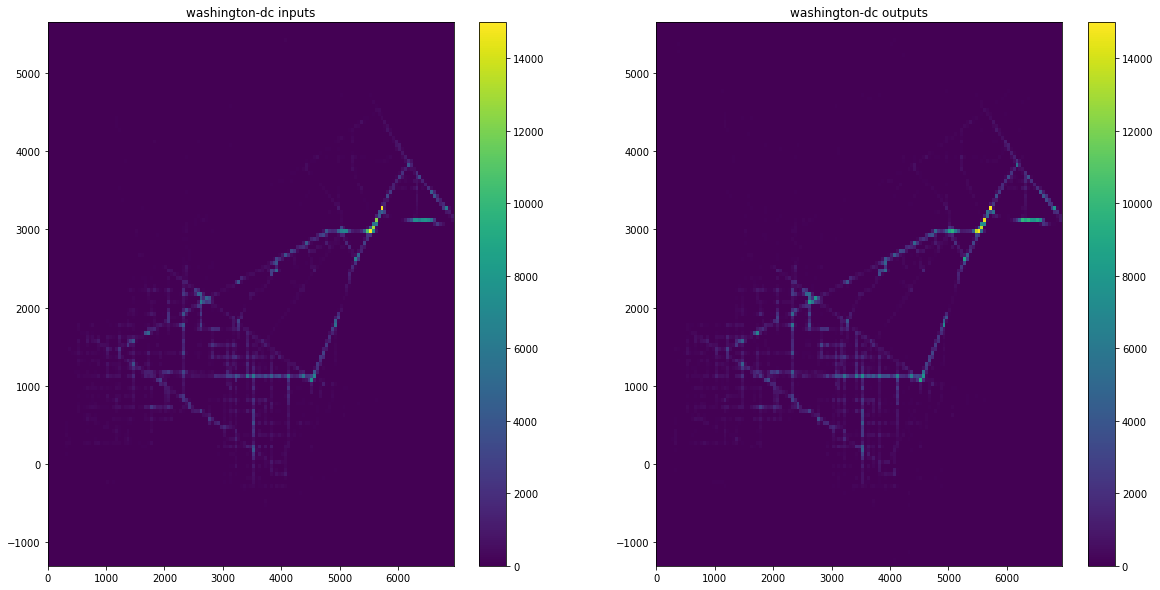

In [11]:
x1 = []
y1 = []
for i in range(train_datasets[4].inputs.shape[1]):
    curr = train_datasets[4].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig5 = plt.figure(figsize=(20,10))
ax9 = fig5.add_subplot(121)
counts, xedges, yedges, im = ax9.hist2d(x1, y1, bins=[np.arange(0,7000,50),np.arange(-1300,5700,50)],
                                       vmin=0, vmax=15000)
fig5.colorbar(im, ax=ax9)
ax9.set_title("washington-dc inputs")

x2 = []
y2 = []
for i in range(train_datasets[4].outputs.shape[1]):
    curr = train_datasets[4].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax10 = fig5.add_subplot(122)
counts, xedges, yedges, im = ax10.hist2d(x2, y2, bins=[np.arange(0,7000,50),np.arange(-1300,5700,50)],
                                       vmin=0, vmax=15000)
fig5.colorbar(im, ax=ax10)
ax10.set_title("washington-dc outputs")

print(f'washington-dc stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

palo-alto stats:
min x1: -5032.128190481392, max x1: 2234.1020005405303
min y1: -2575.73710565541, max y1: 3773.5724851573327
min x2: -5056.2509476956575, max x2: 2233.6892871811247
min y2: -2584.137453651663, max y2: 3755.651010835162


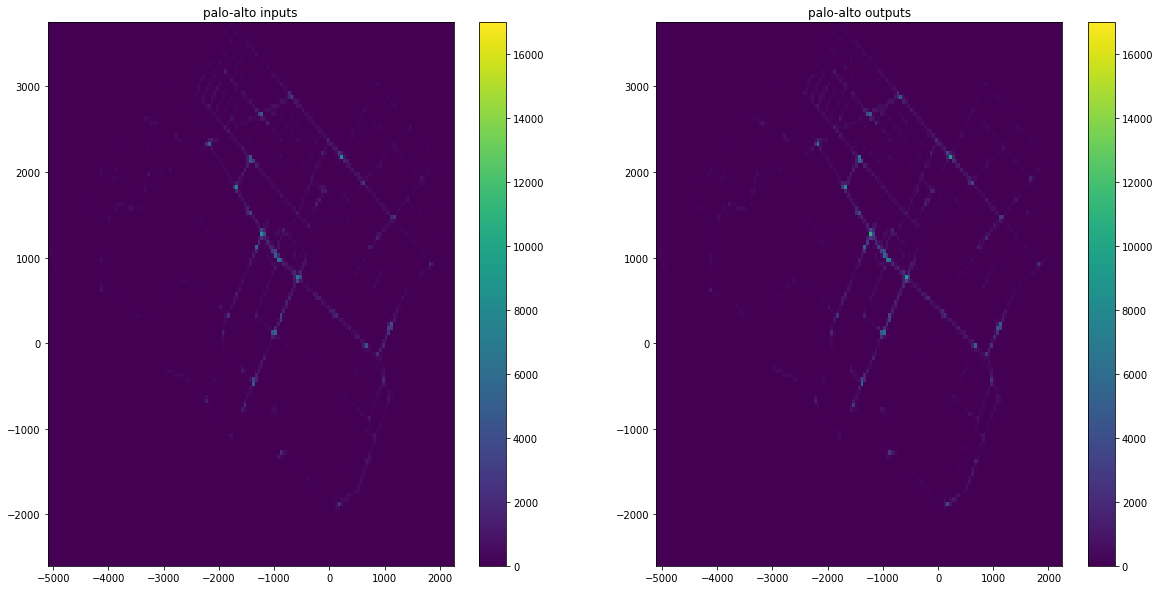

In [12]:
x1 = []
y1 = []
for i in range(train_datasets[5].inputs.shape[1]):
    curr = train_datasets[5].inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig6 = plt.figure(figsize=(20,10))
ax1 = fig6.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(-5100,2300,50),np.arange(-2600,3800,50)],
                                       vmin=0, vmax=17000)
fig6.colorbar(im, ax=ax1)
ax1.set_title("palo-alto inputs")

x2 = []
y2 = []
for i in range(train_datasets[5].outputs.shape[1]):
    curr = train_datasets[5].outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig6.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(-5100,2300,50),np.arange(-2600,3800,50)],
                                       vmin=0, vmax=17000)
fig6.colorbar(im, ax=ax2)
ax2.set_title("palo-alto outputs")

print(f'palo-alto stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

[[-371.96785666  869.71348336]
 [-371.96756372  869.71600158]
 [-371.96723834  869.71753311]
 [-371.96716828  869.71599412]
 [-371.9675969   869.71193979]
 [-371.96823489  869.70809226]
 [-371.96888099  869.70466559]
 [-371.96934622  869.70343168]
 [-371.96957603  869.7037638 ]
 [-371.96977899  869.70374602]
 [-371.97002555  869.70356576]
 [-371.97039818  869.70305325]
 [-371.97103546  869.70182277]
 [-371.97191126  869.70042326]
 [-371.97279815  869.6987388 ]
 [-371.97345433  869.69538059]
 [-371.97390548  869.6896443 ]
 [-371.97417489  869.68245386]
 [-371.9743153   869.67550612]
 [-371.97428966  869.66794082]
 [-371.97409826  869.65871602]
 [-371.97382185  869.64980779]
 [-371.97343716  869.64310184]
 [-371.9735639   869.63051126]
 [-371.97374784  869.61559262]
 [-371.97313077  869.60818553]
 [-371.97176543  869.6062543 ]
 [-371.97002856  869.6063771 ]
 [-371.96819062  869.60736878]
 [-371.96616788  869.61063711]
 [-371.96447267  869.61609171]
 [-371.96331133  869.62357742]
 [-371.9

KeyboardInterrupt: 

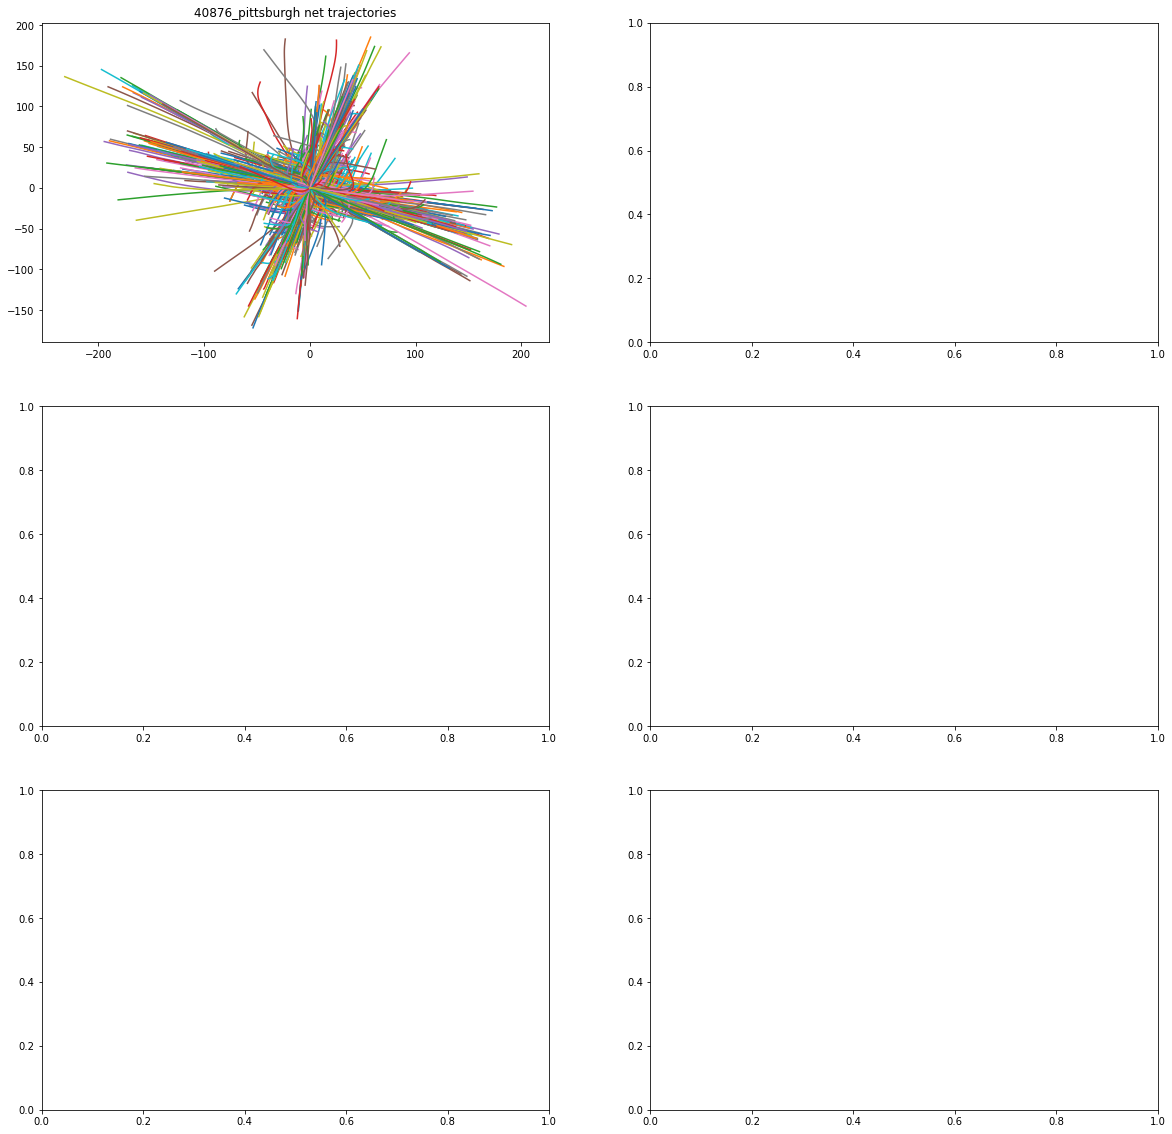

In [324]:
fig7, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for i in range(len(train_datasets)):
    
    x = i // 2
    y = i % 2
    
    for j in range(train_datasets[i].inputs.shape[0]):
        
        to_plot_input = train_datasets[i].inputs[j,:,:]
        to_plot_output = train_datasets[i].outputs[j,:,:]
        if i == 0 and j == 0:
            print(to_plot_output)
        
        to_plot = np.vstack((to_plot_input, to_plot_output))
        plot_x = to_plot[:,0] - to_plot[:,0][0]
        plot_y = to_plot[:,1] - to_plot[:,1][0]
        
        axs[x][y].plot(plot_x, plot_y)
        axs[x][y].set_title(f'{cities[i]} net trajectories')   

In [11]:
len(train_datasets)

6

In [12]:
cities

['austin', 'miami', 'pittsburgh', 'dearborn', 'washington-dc', 'palo-alto']

### Create a DataLoader class for aggregate exploration

In [503]:
class ArgoverseDatasetConcat(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, cities:list, split:str, transform=None):
        
        super(ArgoverseDatasetConcat, self).__init__()
        
        self.transform = transform
        self.split = split
        self.inputs, self.outputs = get_city_trajectories(city=cities[0], split=split, normalized=False)
        self.cities = [cities[0]]*len(self.inputs)
        count = 0
        for i in range(len(self.inputs)):
            self.cities[i] = str(count) + '_' + self.cities[i]
            count += 1
        
        for city in cities[1:]:
            city_inputs,city_outputs  = get_city_trajectories(city=city, split=split, normalized=False)
            self.inputs = np.vstack([self.inputs,city_inputs])
            if split != 'test':
                self.outputs = np.vstack([self.outputs,city_outputs])
                
            new_city_labels = [city]*len(city_inputs)
            count = 0
            for i in range(len(city_inputs)):
                new_city_labels[i] = str(count) + '_' + new_city_labels[i]
                count += 1
            self.cities += new_city_labels
         
         #if self.split == 'test':
             #print(self.cities)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if self.split == 'test':
            return (torch.from_numpy(self.inputs[idx]).float(), self.cities[idx])
        
        data = (torch.from_numpy(self.inputs[idx]).float(), torch.from_numpy(self.outputs[idx]).float(),
                self.cities[idx])
            
        if self.transform:
            data = self.transform(data)

        return data



In [504]:
# initialize concat dataset

train_dataset = ArgoverseDatasetConcat(cities=cities, split='train')
test_dataset = ArgoverseDatasetConcat(cities=cities, split='test')
# test_datasets = []

# for city in cities:
#     train_dataset = ArgoverseDataset(city=city, split='train')
#     test_dataset = ArgoverseDataset(city=city, split='test')
    
#     #train_datasets.append(train_dataset)
#     test_datasets.append(test_dataset)
    
# for test in test_datasets:
#     print(f'{test.city}: {test.inputs.shape}')

aggregate stats:
min x1: -9222.61470641863, max x1: 13295.106948135915
min y1: -4535.476698992521, max y1: 7098.011178254607
min x2: -9231.75573256512, max x2: 13318.46759457012
min y2: -4539.313391138148, max y2: 7048.918470569207


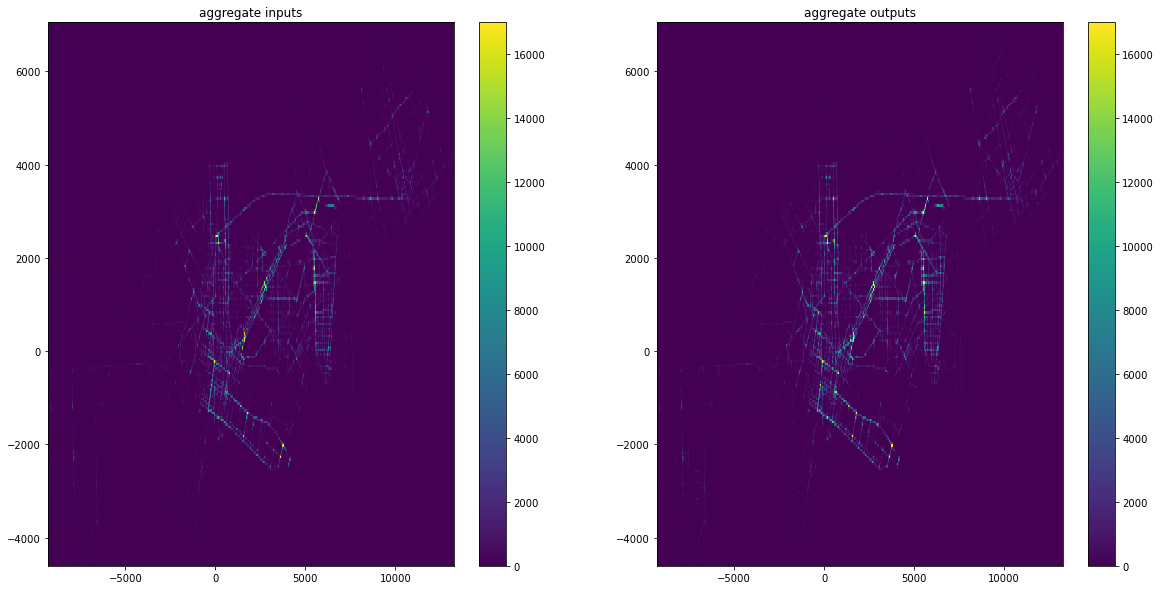

In [505]:
x1 = []
y1 = []
for i in range(train_dataset.inputs.shape[1]):
    curr = train_dataset.inputs[:,i,:]
    x1 += list(curr[:,0])
    y1 += list(curr[:,1])
fig8 = plt.figure(figsize=(20,10))
ax1 = fig8.add_subplot(121)
counts, xedges, yedges, im = ax1.hist2d(x1, y1, bins=[np.arange(-9300,13300,50),np.arange(-4600,7100,50)],
                                       vmin=0, vmax=17000)
fig8.colorbar(im, ax=ax1)
ax1.set_title("aggregate inputs")

x2 = []
y2 = []
for i in range(train_dataset.outputs.shape[1]):
    curr = train_dataset.outputs[:,i,:]
    x2 += list(curr[:,0])
    y2 += list(curr[:,1])
ax2 = fig8.add_subplot(122)
counts, xedges, yedges, im = ax2.hist2d(x2, y2, bins=[np.arange(-9300,13300,50),np.arange(-4600,7100,50)],
                                       vmin=0, vmax=17000)
fig8.colorbar(im, ax=ax2)
ax2.set_title("aggregate outputs")

print(f'aggregate stats:')
print(f'min x1: {min(x1)}, max x1: {max(x1)}')
print(f'min y1: {min(y1)}, max y1: {max(y1)}')
print(f'min x2: {min(x2)}, max x2: {max(x2)}')
print(f'min y2: {min(y2)}, max y2: {max(y2)}')

# Deep Learning Model and Experiment Design

In [506]:
batch_sz = 100  # batch size 
train_perc = 0.9
train_size = int(len(train_dataset)*train_perc)
val_size = len(train_dataset) - train_size
               
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])
               
train_loader = DataLoader(train_data,batch_size=batch_sz, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_sz, shuffle=False, drop_last=True)
               
test_loader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=False)


In [507]:
#for test in test_datasets:
#    print(f'{test.city}: {test.inputs.shape}')
# for batch in test_loader:
#     print('batch!')

## Sample a batch of data and visualize 

In [508]:
def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1], c='orange')
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

ValueError: too many values to unpack (expected 2)

# LR

https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

In [509]:
class LinearRegression(torch.nn.Module):
    
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        #self.loss_fn = torch.nn.functional.mse_loss()

    def forward(self, x):
        #print(x.shape)
        #x = x.float()
        out = self.linear(x)
        return out

In [530]:
input_dim = 50
output_dim = 60
learning_rate = 1e-4
num_epochs = 100
weight_dec = 0.001

model = LinearRegression(input_dim, output_dim)
#model = model.double()

if torch.cuda.is_available():
    model.cuda()

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_dec)

In [531]:
validation_losses =[]
train_losses = []

for epoch in tqdm(range(num_epochs), desc='epoch', leave=False):
    
    train_loss_curr = []
    model.train()
    
    for x_train, y_train, cities in tqdm(train_loader, desc='batch', leave=False):
        
        #loss = 0
    
        # Converting inputs and labels to Variable
        if torch.cuda.is_available():
            inputs = x_train.permute(0,2,1).cuda()
            labels = y_train.permute(0,2,1).cuda()
        else:
            inputs = x_train.permute(0,2,1)
            labels = y_train.permute(0,2,1)
            
        

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs)
        #print(outputs.shape)

        # get loss for the predicted output
        loss = loss_fn(outputs, labels)
        # get gradients w.r.t to parameters
        loss.backward()
        #print(f'loss: {loss.item()}')
        
        train_loss_curr.append(loss.item())

        # update parameters
        optimizer.step()

    if epoch%10 == 0 and epoch!=0:
        model.eval()

        val_loss_tot = []
        for x_test, y_test, cities in tqdm(val_loader, desc='test_batch', leave=False):

            x_test = x_test.permute(0,2,1)
            y_test = y_test.permute(0,2,1)

            if torch.cuda.is_available():
                x_test, y_test = x_test.cuda(), y_test.cuda()

            prediction = model(x_test)
            valid_loss = loss_fn(prediction, labels)
            val_loss_tot.append(valid_loss.item())
            #print(f'val_loss_tot: {val_loss_tot}')

        avg_val_loss = sum(val_loss_tot)/len(val_loss_tot)
        validation_losses.append(avg_val_loss)

        if len(validation_losses) >= 2:# and avg_val_loss < validation_losses[-2]:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'validation_losses': validation_losses
            }, f'model_{epoch}_best.pt')
            
    if epoch%15 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'validation_losses': validation_losses
        }, f'model_{epoch}_time.pt')

        #break

    train_losses.append(sum(train_loss_curr)/len(train_loss_curr))
    print(f'epoch {epoch}, loss {train_losses[-1]}', end='\r')
    

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

test_batch:   0%|          | 0/203 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

test_batch:   0%|          | 0/203 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

test_batch:   0%|          | 0/203 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

test_batch:   0%|          | 0/203 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

test_batch:   0%|          | 0/203 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

test_batch:   0%|          | 0/203 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

test_batch:   0%|          | 0/203 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

test_batch:   0%|          | 0/203 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

test_batch:   0%|          | 0/203 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

batch:   0%|          | 0/1834 [00:00<?, ?it/s]

[13223933.57142857, 14831970.42857143, 14401028.108374385, 13492099.27093596, 13235925.054187192, 11962343.472906403, 14144772.433497537, 14084987.108374385, 16120443.837438423]


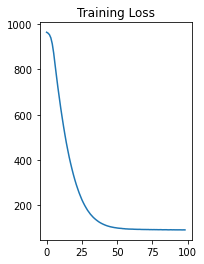

In [532]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(train_losses[1:])
ax1.set_title("Training Loss")
# ax2 = fig.add_subplot(122)
# ax2.plot(validation_losses)
# ax2.set_title("Validation Loss")

print(validation_losses)

In [533]:
predictions_test = np.array([])
cities_test = np.array([])

with torch.no_grad(): # we don't need gradients in the testing phase
    predicted = np.array([])
    
    #print(type(test_loader))
    
    for x_test, cities in tqdm(test_loader, desc='test_batch', leave=False):
        
        #print(type(batch))
        
        input_test = torch.from_numpy(np.array(x_test)).permute(0,2,1)
     
        if torch.cuda.is_available():
            input_test = input_test.cuda()
            
        curr_predict = model(input_test)
        #print(curr_predict.shape)
        
    
        if torch.cuda.is_available():
            predicted = curr_predict.cpu().data.numpy()
        else:
            predicted = curr_predict.data.numpy()
        
        #print(predicted.shape)
        if len(predictions_test) == 0:
            predictions_test = predicted
            #cities_test = cities
        else:   
            predictions_test = np.vstack([predictions_test, predicted])
            
        cities_test = np.concatenate([cities_test, cities])

        
print(predictions_test.shape)
print(cities_test.shape)
    
#print(predictions_test[:10])
#print(cities_test[len(cities_test)-10:])

test_batch:   0%|          | 0/299 [00:00<?, ?it/s]

(29843, 2, 60)
(29843,)


# Output Results to File

In [534]:
trajectory_table = pd.read_csv('sample_submission.csv')
trajectory_table.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [535]:
trajectory_table.tail()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
29838,1681_palo-alto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29839,1682_palo-alto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29840,1683_palo-alto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29841,1684_palo-alto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29842,1685_palo-alto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [536]:
trajectory_table.at[0, 'v0']

0

In [537]:
for i in range(len(predictions_test)):
    
    curr_col = 0
    traj_pred = predictions_test[i]
    
    for j in range(traj_pred.shape[1]):
        col1 = 'v'+str(curr_col)
        col2 = 'v'+str(curr_col+1)
        
        trajectory_table.at[i, col1] = np.float64(traj_pred[0][j])
        trajectory_table.at[i, col2] = np.float64(traj_pred[1][j])
        curr_col += 2
    #break

In [538]:
trajectory_table.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-12.341942,-567.417786,-13.223516,-567.156555,-13.862452,-566.959412,-14.867785,-566.634460,-15.532228,...,-52.803848,-554.632080,-53.372379,-554.440491,-53.708782,-554.246155,-53.924629,-554.173706,-54.327972,-554.018738
1,1_austin,-347.733582,10.369310,-348.416321,9.332835,-348.630493,8.679592,-348.375214,8.027102,-347.971191,...,-351.018707,-22.076084,-349.602722,-21.510433,-352.093536,-23.311497,-351.237244,-23.052168,-351.810730,-23.780731
2,2_austin,50.996471,-247.723495,50.989864,-247.729477,50.996517,-247.725800,50.986801,-247.723221,50.996105,...,51.049297,-247.736801,51.061749,-247.732971,51.037930,-247.692184,51.047508,-247.689835,51.039150,-247.678879
3,3_austin,-113.867355,1798.665771,-113.842339,1798.830933,-113.867645,1798.977173,-113.744385,1799.053223,-113.765564,...,-112.829956,1805.561768,-112.721848,1805.609741,-112.846031,1805.435303,-112.849144,1805.478394,-112.855270,1805.445679
4,4_austin,1196.184448,-638.165466,1197.489258,-638.652893,1198.436279,-639.103394,1199.523926,-639.460510,1200.505981,...,1250.439331,-660.026550,1250.919800,-660.226562,1251.819092,-660.527222,1251.847778,-660.612244,1252.391113,-660.789368


In [539]:
trajectory_table.to_csv('submission_test.csv', index=False)

# Experiment Results and Future Work

In [549]:
sample_size = 25
sample_data, _ = torch.utils.data.random_split(train_dataset, [sample_size, len(train_dataset)-sample_size])
sample_loader = DataLoader(sample_data,batch_size=1, shuffle=False, drop_last=True)

In [550]:
predictions_test = np.array([])
cities_test = np.array([])

with torch.no_grad(): # we don't need gradients in the testing phase
    predicted = np.array([])
    
    #print(type(test_loader))
    
    for x_test, _, cities in sample_loader:#tqdm(sample_loader, desc='sample_batch', leave=False):
        
        input_test = torch.from_numpy(np.array(x_test)).permute(0,2,1)
     
        if torch.cuda.is_available():
            input_test = input_test.cuda()
            
        curr_predict = model(input_test)
        #print(curr_predict.shape)
        
    
        if torch.cuda.is_available():
            predicted = curr_predict.cpu().data.numpy()
        else:
            predicted = curr_predict.data.numpy()
        
        #print(predicted.shape)
        if len(predictions_test) == 0:
            predictions_test = predicted
            #cities_test = cities
        else:   
            predictions_test = np.vstack([predictions_test, predicted])
            
        cities_test = np.concatenate([cities_test, cities])

        
print(predictions_test.shape)
print(cities_test.shape)
    
#print(predictions_test[:10])
#print(cities_test[len(cities_test)-10:])

(25, 2, 60)
(25,)


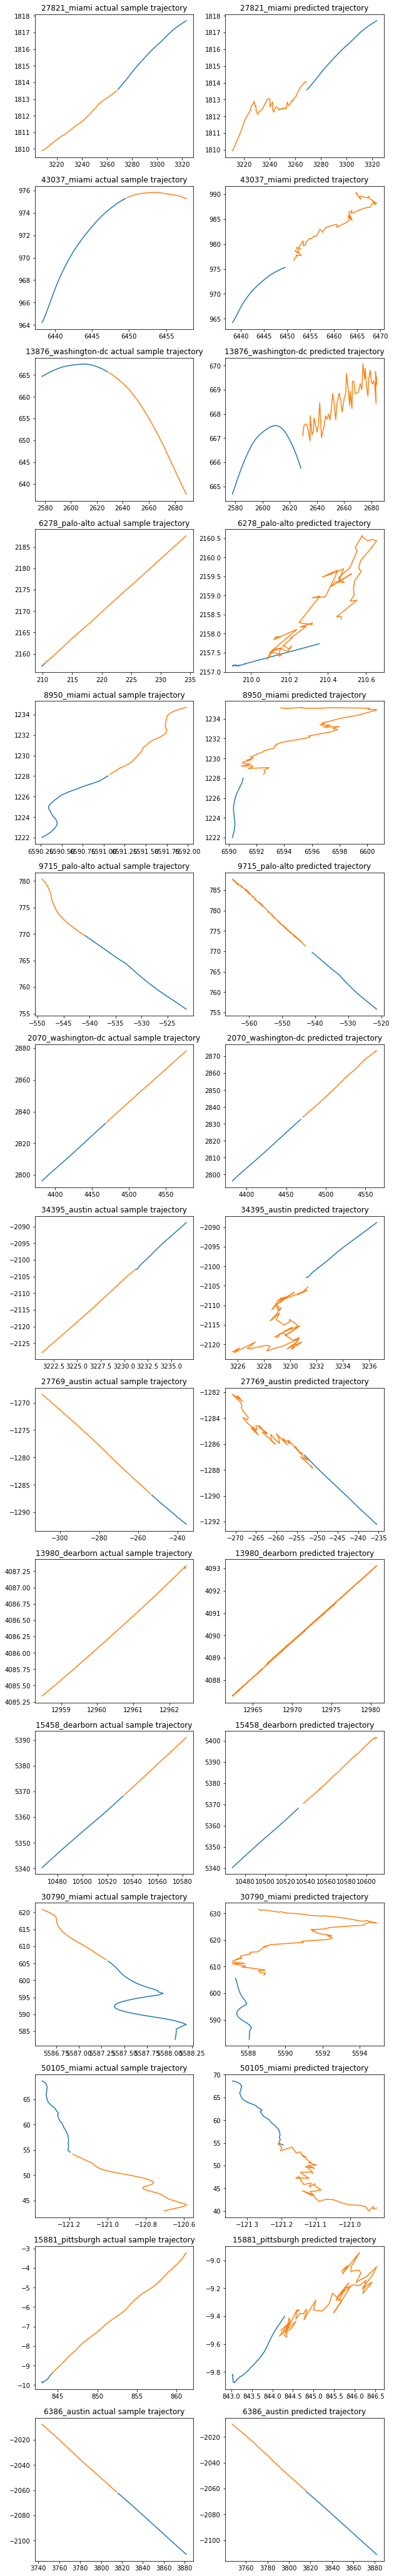

In [548]:
fig8, axs = plt.subplots(nrows=sample_size, ncols=2, figsize=(10,sample_size*5))

for i in range(sample_size):
    # plot actual trajectory
    x = i
    y = 0
    
    to_plot_input = sample_data[i][0]#.inputs[j,:,:]
    to_plot_output = sample_data[i][1]#.outputs[j,:,:]
    plot_x_input = to_plot_input[:,0]
    plot_y_input = to_plot_input[:,1]
    plot_x_output = to_plot_output[:,0]
    plot_y_output = to_plot_output[:,1]

    axs[x][y].plot(plot_x_input, plot_y_input)
    axs[x][y].plot(plot_x_output, plot_y_output)
    axs[x][y].set_title(f'{sample_data[i][2]} actual sample trajectory')
    
    # plot predicted trajectory
    y += 1
    to_plot_input = sample_data[i][0]#.inputs[j,:,:]  
    to_plot_output = predictions_test[i]#.outputs[j,:,:]
    plot_x_input = to_plot_input[:,0]
    plot_y_input = to_plot_input[:,1]
    plot_x_output = to_plot_output[0]
    plot_y_output = to_plot_output[1]

    axs[x][y].plot(plot_x_input, plot_y_input)
    axs[x][y].plot(plot_x_output, plot_y_output)
    axs[x][y].set_title(f'{sample_data[i][2]} predicted trajectory')

# Defining and Training an RNN

In [375]:
# class Net(nn.Module):
#     def __init__(self, input_size, output_size, hidden_size, num_layers=1, nonlinearity=tanh, dropout=False):
        
#         self.input_size = input_size
#         self.output_size = output_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
        
#         super(Net, self).__init__()
        
#         # RNN layer
#         self.rnn = nn.RNN(input_size, hidden_dim, n_layers=n_layers, batch_first=True)
        
#         # fully connected output
#         self.fc = nn.Linear(hidden_dim, output_size)
        